### ctxt Packing
Joonwoo Lee et al 2021 paces a channel of an image in a ctxt, 
using only 1024 slots out of 16384. (sparse packing)

### Narrow Resnet
Their 'ResNet-20' is a modified and simplified version of the original ResNet. 
First, they use only three basic blocks, while Resnet-18 consists of four. 
Second, they reduced the number of channels.  
The first conv outputs 16 channels, instad of 64. 
The final number of channels is thus only 64. (Resnet-18 with four basic blocks ends up with 512 channels)
This modification is reasonable because computations are done in per-channel manner. 
The total computing cost grows linearly with growing number of channels.  

### AvgPool
마지막에 AvgPool 하나와 FC가 하나 있음. 8x8 이미지를 8x8 kernel로 AvgPool해서 1 x 64-channel 이 됨. 
그 다음에 64개의 ctxt가 하나의 ctxt로 합쳐짐.  -- 어떻게 잘 합칠까? 

### Softmax
Approximate softmax는 계산량이 상당히 많음. 
그러다고 softmax 없이 training을 할 수는 없음 (argmax는 differentiable하지 않으므로)
1. softmax로 훈련한 뒤에 argmax로 교체해서 evaluate하거나 
2.그 전에 decrypt해서 plain text에 softmax 계산하거나


In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


Prepare Train / test data sets

In [3]:
num_workers = 0
batch_size = 32
valid_size = 0.2


## Scale 
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (2.5, 2.5, 2.5))
     ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True,
                              transform=transform
                             )
test_data = datasets.CIFAR10('data', train=False,
                             download=True, 
                             transform=transform
                            )

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Simple CNN with two convolutions

In [20]:
import copy

def myrelu(xx):
    return xx * (1+torch.sign(xx))/2

def approx_relu2(x):
    return 0.47 + 0.5*x + 0.09*x**2

def approx_relu5(x):    
    return 0.29 + 0.5*x + 0.16*x**2 - 1.6e-8*x**3 - 3.3e-3 * x**4

def approx_relu5B(x):
    B = 5
    return B * (0.29 + 0.5*(x/B) + 0.16*(x/B)**2 - 1.6e-8*(x/B)**3 - 3.3e-3 * (x/B)**4)

def approx_relu8(x):
    B = 35
    return B * (0.17 + 0.5*(x/B) + 0.29 * (x/B)**2 - 1.4e-7*(x/B)**3 - 2.6e-2*(x/B)**4 +\
                9.7e-9 * (x/B)**5 + 1.2e-3*(x/B)**6 - 2.0e-10*(x/B)**7 - 2.1e-5*(x/B)**8)

def relu_mm(x):
    f1 = 7.30445165*x -3.468258711e1*x**3 + 5.985965183e1 * x**5 - 3.187552259e1 * x**7
    f2 = 2.400856522*x -2.6312545426*x**3 + 1.5491267477*x**5 - 3.311729565e-1*x**7
    
    
activation = [myrelu, approx_relu8, approx_relu5B, F.relu, approx_relu2, approx_relu5, F.silu, torch.square][6]
    
import torchvision

In [16]:
f1 = lambda x :  7.30445165*x -3.468258711e1*x**3 + 5.985965183e1 * x**5 - 3.187552259e1 * x**7
f2 = lambda x : 2.400856522*x -2.6312545426*x**3 + 1.5491267477*x**5 - 3.311729565e-1*x**7

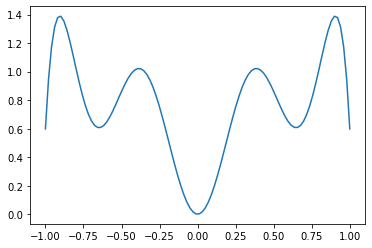

In [17]:
x = np.linspace(-1,1, 100)
plt.plot(x, f1(x) * f2(x))
plt.show()


In [152]:
xx = np.linspace(-50,50,100)

#plt.plot(xx, approx_relu5(xx), label = 'appr5')
plt.plot(xx, approx_relu5B(xx), label = 'appr5B')
plt.plot(xx, approx_relu8(xx), label = 'appr8')
plt.plot(xx, xx * (1+np.sign(xx))/2, label = 'exact')
plt.legend()
plt.show()



RELU 결과가 -0.9?
ReLU로 들어가는 값이 -5.x로 안전한 영역을 지나쳤음. 

### 텐서 크기 
1024 * 3  -> 1024 * 32 -> 256 * 32 -> 256 * 64 -> 64 * 64 -> 64 * 128 -> 16 * 128 -> 2048 -> 256 -> 10


1024 * 32는 여러 개의 ctxt에 담아야함.  

아니면 첫번째 convolution 채널을 작게 유지하고,   
average pooling을 묶어서 계산할 수는 없을까.  

In [21]:
import ResNet20

print(activation)

if True:
    model = ResNet20.ResNet20(activation=activation)

#model.to('cpu')
train_on_gpu=True

print(model)

<function silu at 0x7f551d0fc8b0>
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16

## Optimizer

In [22]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# For ResNet
optimizer = optim.SGD(model.parameters(), lr=.01, weight_decay=5e-4, momentum = 0.9)



## Training

activation을 approximate relu로 설정하면 loss = nan 나옴. 
1. input range 체크 
2. 중간값 범위 체크

In [23]:
fn_pt = 'ResNet_20_silu.pt'

n_epochs = 15
train_losslist=[]
valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.to(device)
    model.train()
    
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        #print("DATA", data[0,0,0])
        output = model(data)
        #print("weight", model.conv1.weight[0,0,0])
        #print(output[0,:])
        #print(output.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #print("VALID-------------------------------------------------------------------")
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), fn_pt)
        valid_loss_min = valid_loss
        

Epoch: 1 	Training Loss: 1.131902 	Validation Loss: 0.245982
Validation loss decreased (inf --> 0.245982).  Saving model ...
Epoch: 2 	Training Loss: 0.783682 	Validation Loss: 0.189975
Validation loss decreased (0.245982 --> 0.189975).  Saving model ...
Epoch: 3 	Training Loss: 0.651181 	Validation Loss: 0.152378
Validation loss decreased (0.189975 --> 0.152378).  Saving model ...
Epoch: 4 	Training Loss: 0.564488 	Validation Loss: 0.145534
Validation loss decreased (0.152378 --> 0.145534).  Saving model ...
Epoch: 5 	Training Loss: 0.504555 	Validation Loss: 0.145879
Epoch: 6 	Training Loss: 0.459754 	Validation Loss: 0.128281
Validation loss decreased (0.145534 --> 0.128281).  Saving model ...
Epoch: 7 	Training Loss: 0.421200 	Validation Loss: 0.125258
Validation loss decreased (0.128281 --> 0.125258).  Saving model ...
Epoch: 8 	Training Loss: 0.390456 	Validation Loss: 0.120712
Validation loss decreased (0.125258 --> 0.120712).  Saving model ...
Epoch: 9 	Training Loss: 0.364320 

In [24]:
# Load the best one
model.load_state_dict(torch.load(fn_pt))

<All keys matched successfully>

In [25]:
# track test loss
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
    num_workers=num_workers)

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.590922

Test Accuracy of airplane: 84% (846/1000)
Test Accuracy of automobile: 87% (878/1000)
Test Accuracy of  bird: 69% (697/1000)
Test Accuracy of   cat: 67% (676/1000)
Test Accuracy of  deer: 84% (848/1000)
Test Accuracy of   dog: 72% (728/1000)
Test Accuracy of  frog: 79% (797/1000)
Test Accuracy of horse: 84% (840/1000)
Test Accuracy of  ship: 92% (920/1000)
Test Accuracy of truck: 82% (822/1000)

Test Accuracy (Overall): 80% (8052/10000)


## Replace activation and hope for a reasonable performance!

#### or, do a little bit of fine tune

In [ ]:
for name,child in net.named_children():
    if isinstance(child,nn.ReLU) or isinstance(child,nn.SELU):
        net._modules['relu'] = nn.SELU()